### Example

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import mpl_toolkits.axes_grid1 as axes_grid1
# np.random.seed(1)

# data = np.random.randint(0, 1000, (10, 10), )

# fig = plt.figure(dpi = 150)
# grid = axes_grid1.AxesGrid(
#     fig, 111, nrows_ncols=(1, 2), axes_pad = 0.5, cbar_location = "right",
#     cbar_mode="each", cbar_size="15%", cbar_pad="5%",)

# im0 = grid[0].imshow(data > 500, cmap='gray', interpolation='nearest')
# grid.cbar_axes[0].colorbar(im0)

# im1 = grid[1].imshow(data, cmap='jet', interpolation='nearest')
# grid.cbar_axes[1].colorbar(im1)

# plt.show()
# plt.close()

In [2]:
# data

----

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp
import networkx as nx

from matplotlib import gridspec

import sys

In [4]:
sys.path.append('../')

In [5]:
from common_functions import eval_g_hat_with_DnX

In [6]:
p2root = '../results_0905_logging/'
K = 25
version='Rr'
iteration = 10000
iid_sample = 20000
chromo = 'chr3L'
expr_name = f'{chromo}_drosophila_ChIA_Drop_0.1_PASS'
prefix = f'{expr_name}_{iid_sample}_MCMC_pivot_K_{K}_iter_{iteration}'
# prefix = f'{expr_name}_{iid_sample}_K_{K}_iter_{iteration}'
# p2nmf_dict = osp.join(p2root, f'{prefix}_nmf_centroid_df')
# p2cmf_dict = osp.join(p2root, f'{prefix}_cmf_centroid_df')
# p2omf_dict = osp.join(p2root, f'{prefix}_omf_centroid_df')

p2ocmf_dict = osp.join(p2root, f'{version}_{prefix}_ocmf_centroid_df')
p2representative_regions = osp.join(p2root, f'{version}_{prefix}_x_hat_df')
p2A_t = osp.join(p2root, f'A_t_{version}_{prefix}_ocmf.csv')
p2W_hat = osp.join(p2root, f'W_hat_{version}_{prefix}_ocmf.csv')
p2X = osp.join(p2root, f'{prefix}_X_df')

In [7]:
p2X

'../results_0905_logging/chr3L_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot_K_25_iter_10000_X_df'

In [8]:
X_df = pd.read_pickle(p2X)
# nmf_dict = pd.read_pickle(p2nmf_dict)
# cmf_dict = pd.read_pickle(p2cmf_dict)
# omf_dict = pd.read_pickle(p2omf_dict)
ocmf_dict = pd.read_pickle(p2ocmf_dict)
rep_region = pd.read_pickle(p2representative_regions)

In [9]:
W_hat = np.loadtxt(p2W_hat, delimiter=',')
A_t = np.loadtxt(p2A_t, delimiter=',')

In [10]:
(W_hat > 0).astype(int)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [11]:
rep_region.label.value_counts()

group 13    32
group 16    30
group 15    28
group 4     25
group 5     22
group 17    19
group 22    19
group 19    14
group 2     14
group 3     14
group 23    13
group 6     13
group 7     11
group 1     11
group 18    10
group 11    10
group 9     10
group 12    10
group 10    10
group 24    10
group 20    10
group 0     10
group 21    10
group 8     10
group 14    10
Name: label, dtype: int64

## Read node embedding data for genome location

In [12]:
# p2raw_data = '/data/shared/jianhao/online_cvxNDL_data/new_data_with_node_id/'
# p2raw_data = '/data/shared/jianhao/online_cvxNDL_data/updated_0905_data_with_node_id/'

# p2emb = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}_sample_node_matrix')
# p2raw_data = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}')

p2raw_data = '/data/shared/jianhao/online_cvxNDL_data/updated_0905_data_with_node_id'
p2emb = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}_MCMC_pivot_sample_node_matrix')
p2raw_data = osp.join(p2raw_data, f'df_{expr_name}_{iid_sample}_MCMC_pivot')

In [13]:
df_node_all = pd.read_pickle(p2emb)
df_subgraph_all = pd.read_pickle(p2raw_data).drop(columns = ['label'])
# df_subgraph_all_old = pd.read_pickle(p2raw_data_old).drop(columns = ['label'])

### check which dataset used in training.
if use old subgraph, then subgraph may not have correponding node embeddings.


In [14]:
# if (X_df.values == df_subgraph_all_old.values).all():
#     print('>>> used old dataset without node embedding!!!! Change later on.')
#     df_raw_data = df_subgraph_all_old
#     warning_flag = True
#     df_raw_data_matched_emb = df_subgraph_all
    
if (X_df.values == df_subgraph_all.values).all():
    print('>>> used new dataset with node embeddings. GOOD to go.')
    df_raw_data = df_subgraph_all
    warning_flag = False
    df_raw_data_matched_emb = df_subgraph_all

>>> used new dataset with node embeddings. GOOD to go.


### 1. df_raw_data will always be the input data. So df_rep.isin(df_raw_data) == True. 
only case is that when used old data:

=> **df_node_emb** and **df_raw_data** does not match. 

### 2. df_raw_data_matched_emb will always matched the node embedding

In [15]:
df_node_all

,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,...,node_11,node_12,node_13,node_14,node_15,node_16,node_17,node_18,node_19,node_20
0,V41331,V1284,V1255,V1540,V18894,V1540,V1315,V1219,V1233,V9956,...,V44139,V7807,V17394,V16705,V19690,V8457,V9499,V32082,V18737,V18660
1,V1284,V1349,V1363,V43418,V1363,V1306,V35821,V35850,V35783,V35799,...,V35799,V19345,V35799,V35781,V35849,V35880,V25292,V3939,V5692,V17395
2,V24386,V5147,V32020,V32079,V1689,V6823,V6702,V6736,V33055,V6736,...,V608,V17041,V9057,V17065,V17122,V17041,V6446,V28096,V6446,V41308
3,V1307,V241,V1307,V41329,V1307,V26049,V7803,V1303,V1542,V1559,...,V17348,V8142,V6828,V8825,V9129,V22598,V18744,V18735,V42854,V23735
4,V28312,V1220,V8301,V6838,V23631,V32076,V38148,V21712,V29425,V30890,...,V28843,V39731,V29302,V42542,V42532,V42512,V42543,V42523,V38063,V37476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,V24917,V7167,V11529,V7167,V7089,V5269,V7089,V5269,V35802,V30270,...,V30270,V2026,V11516,V23993,V23983,V23993,V17035,V32293,V17035,V1527
19996,V12230,V16361,V10565,V16361,V1299,V47018,V1310,V44379,V1310,V19467,...,V14301,V4948,V24147,V4948,V9469,V4948,V12424,V39569,V47421,V39569
19997,V3375,V19321,V1419,V1306,V39795,V10648,V39795,V38635,V39795,V29253,...,V30992,V44785,V30992,V44726,V44328,V17371,V47736,V17371,V28421,V17371
19998,V44210,V1306,V3592,V1306,V2058,V1306,V12522,V8280,V39576,V21353,...,V30605,V1110,V11528,V23569,V16114,V11497,V11157,V11490,V1774,V35930


In [16]:
X_df

,Principle component 0,Principle component 1,Principle component 2,Principle component 3,Principle component 4,Principle component 5,Principle component 6,Principle component 7,Principle component 8,Principle component 9,...,Principle component 431,Principle component 432,Principle component 433,Principle component 434,Principle component 435,Principle component 436,Principle component 437,Principle component 438,Principle component 439,Principle component 440
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19996,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
19998,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Map X_df / df_raw_data from 0/1 to genome location (i.e. the V_id)

In [17]:
df_Vid_all = df_node_all.applymap(lambda x: int(x.strip('V')))

In [18]:
df_Vid_all.values.min(), df_Vid_all.values.max()

(104, 49072)

In [19]:
def round_to_1_sig(x):
    str_x = str(x)
    if x == int(str_x[0] + '0' * (len(str_x) - 1)):
        return x
    else:
        return (int(str_x[0]) + 1) * (10**(len(str_x) - 1))

In [20]:
vid_lower_bound = 0
vid_upper_bound = round_to_1_sig(df_Vid_all.values.max())

In [21]:
vid_lower_bound, vid_upper_bound

(0, 50000)

In [22]:
def convert_row_in_adj_to_vid(adj_row, vid_row):
    k = len(vid_row)
    row_np = np.array(adj_row)
    vid_np = np.array(vid_row)
    
    row_np = row_np.reshape(k, k)
    new_row = row_np * vid_np
    
    return new_row.reshape(adj_row.shape)

In [23]:
df_genome_mapped_X = X_df.copy()

for idx in range(len(X_df)):
    adj_row = X_df.iloc[idx]
    vid_row = df_Vid_all.iloc[idx]
    new_row = convert_row_in_adj_to_vid(adj_row, vid_row)
    
    df_genome_mapped_X.iloc[idx] = new_row

In [24]:
df_genome_mapped_X

,Principle component 0,Principle component 1,Principle component 2,Principle component 3,Principle component 4,Principle component 5,Principle component 6,Principle component 7,Principle component 8,Principle component 9,...,Principle component 431,Principle component 432,Principle component 433,Principle component 434,Principle component 435,Principle component 436,Principle component 437,Principle component 438,Principle component 439,Principle component 440
0,0.0,1284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18737.0,0.0
1,0.0,1349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35799.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5692.0,0.0
2,0.0,5147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6446.0,0.0,6446.0,0.0
3,0.0,241.0,0.0,41329.0,0.0,26049.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42854.0,0.0
4,0.0,1220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38063.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,7167.0,0.0,7167.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17035.0,0.0,17035.0,0.0
19996,0.0,16361.0,0.0,16361.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12424.0,0.0,47421.0,0.0
19997,0.0,19321.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44726.0,44328.0,0.0,47736.0,0.0,28421.0,0.0
19998,0.0,1306.0,0.0,1306.0,0.0,1306.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1774.0,0.0


-----
## Draw one row

In [25]:
def plot_one_row(ax, row, k = 21, threshold = 1, title = ''):
    row_np = np.array(row)
    if threshold is not None:
        bin_row = (row_np >= threshold).astype(int)
        bin_row_mat = bin_row.reshape(k, k)
    else:
        bin_row_mat = row_np.reshape(k, k)
    
    ax.imshow(bin_row_mat, cmap = 'Greys')
    ax.set_title(title, fontsize = 18)
    ax.set_xticks([])
    ax.set_yticks([])
    return bin_row_mat, ax

def plot_one_color_row(ax, row, k = 21, title = '', vmin = 0, vmax = 1, cmap = 'rainbow'):
    '''
    Each row will be converted into a k * k matrix. 
    '''
    row_np = np.array(row)
    
    row_mat = row_np.reshape(k, k)
    
    im = ax.imshow(row_mat, cmap = cmap, vmin = vmin, vmax = vmax)
    ax.set_title(title, fontsize = 18)
    ax.set_xticks([])
    ax.set_yticks([])
    return row_mat, ax, im 

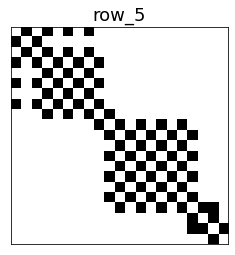

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

plot_one_row(ax, X_df.loc[5], title = 'row_5')
plt.show()
plt.close()

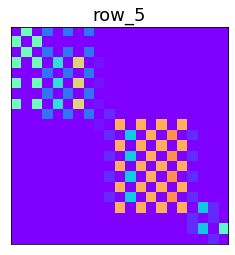

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

plot_one_color_row(ax, df_genome_mapped_X.loc[5], title = 'row_5',
            vmin = vid_lower_bound, vmax = vid_upper_bound)
plt.show()
plt.close()

In [28]:
def plot_df_in_grid(df_in, grid_size = (2, 5), figsize = (10, 4), 
                    k = 21, threshold = 1, title_prefix = 'row', title = '', 
                   sub_titles = None, p2savefig = None):
    fig = plt.figure(figsize = figsize)
    axes = fig.subplots((*grid_size))
    
    for row_idx in range(grid_size[0]):
        for col_idx in range(grid_size[1]):
            ax = axes[row_idx][col_idx]
            
            idx = row_idx * grid_size[1] + col_idx
            if idx < df_in.shape[0]:
                cur_row = df_in.iloc[idx]
            else:
                cur_row = np.zeros_like(df_in.iloc[0].values)
            
            if sub_titles is None:
                subtitle =  f'{title_prefix}_{idx}'
            else:
                if idx < len(sub_titles):
                    subtitle = sub_titles[idx]
                else:
                    subtitle = ''
                
            plot_one_row(ax, cur_row, k = k, threshold= threshold, title = subtitle)
    plt.suptitle(title, fontsize = 18, y = 1.01)
    plt.tight_layout(pad = 0.6, rect = [0, 0, 1, 1.01])
    
    if p2savefig is None:
        plt.show()    
        plt.close()
    else:
        plt.savefig(p2savefig, bbox_inches = 'tight')
        plt.show()
        plt.close()

In [29]:
def plot_df_in_grid_color(df_in, grid_size = (2, 5), figsize = (10, 4), 
                    k = 21, threshold = 1, title_prefix = 'row', title = '', 
                    sub_titles = None, p2savefig = None, 
                    vmin = 0, vmax = 1, cmap = 'rainbow'):
    
    fig = plt.figure(figsize = figsize)
    axes = fig.subplots((*grid_size))
    
    for row_idx in range(grid_size[0]):
        for col_idx in range(grid_size[1]):
            ax = axes[row_idx][col_idx]
            
            idx = row_idx * grid_size[1] + col_idx
            if idx < df_in.shape[0]:
                cur_row = df_in.iloc[idx]
            else:
                cur_row = np.zeros_like(df_in.iloc[0].values)
            
            if sub_titles is None:
                subtitle =  f'{title_prefix}_{idx}'
            else:
                if idx < len(sub_titles):
                    subtitle = sub_titles[idx]
                else:
                    subtitle = ''
                
#             plot_one_row(ax, cur_row, k = k, threshold= threshold, title = subtitle)
            _, _, im = plot_one_color_row(ax, cur_row, k = k, title = subtitle,
                                vmin = vmin, vmax = vmax, cmap = cmap)
            
    plt.suptitle(title, y = 1.05)
    plt.tight_layout()
    
    fig.subplots_adjust(right = 0.9)
    cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.75])
    plt.colorbar(im, cax = cbar_ax)
    
    if p2savefig is None:
        plt.show()    
        plt.close()
    else:
        plt.savefig(p2savefig)
        plt.close()

In [30]:
# plot_df_in_grid(X_df.loc[np.random.choice(X_df.index, 10)], title_prefix= 'random_sample')

In [31]:
# plot_df_in_grid_color(df_genome_mapped_X.loc[np.random.choice(X_df.index, 10)], title_prefix= 'random_sample', 
#                      vmin = vid_lower_bound, vmax = vid_upper_bound, cmap = 'rainbow')

# online cvxMF results

<AxesSubplot:>

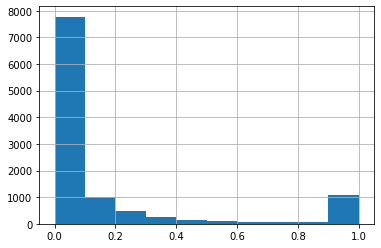

In [32]:
feature = [x for x in ocmf_dict.columns if 'label' not in x]
ocmf_dict_val_df = ocmf_dict[feature]
ocmf_dict_val_df.stack().hist()

In [33]:
def get_importance_from_At(A_t):
    diag = A_t.diagonal()
    sum_diag = sum(diag)
    score = diag / sum_diag
    return score

In [34]:
importance_score = get_importance_from_At(A_t)
# subtitles = [f'online cvxNDL\n dictionaries {x}\n score {importance_score[x]:.2f}' for x in range(ocmf_dict_val_df.shape[0])]
subtitles = [f'dict_{x}\n({importance_score[x]:.3f})' for x in range(ocmf_dict_val_df.shape[0])]

In [35]:
descending_order_of_At = importance_score.argsort()[::-1]

In [36]:
importance_score[descending_order_of_At]

array([0.08047598, 0.07658698, 0.07405919, 0.07394807, 0.07365739,
       0.06762956, 0.05134418, 0.04860674, 0.04545787, 0.03997707,
       0.03682665, 0.03503473, 0.02932818, 0.02851004, 0.0277298 ,
       0.02651209, 0.02466605, 0.02332942, 0.02323378, 0.02313454,
       0.02228146, 0.02062968, 0.0195335 , 0.01803657, 0.00947048])

## sorted dictionary by importance score

In [37]:
sorted_ocmf_dict_val_df_by_At = ocmf_dict_val_df.loc[descending_order_of_At]
sorted_subtitles_by_At = [subtitles[i] for i in descending_order_of_At]

### raw dicitonaries 

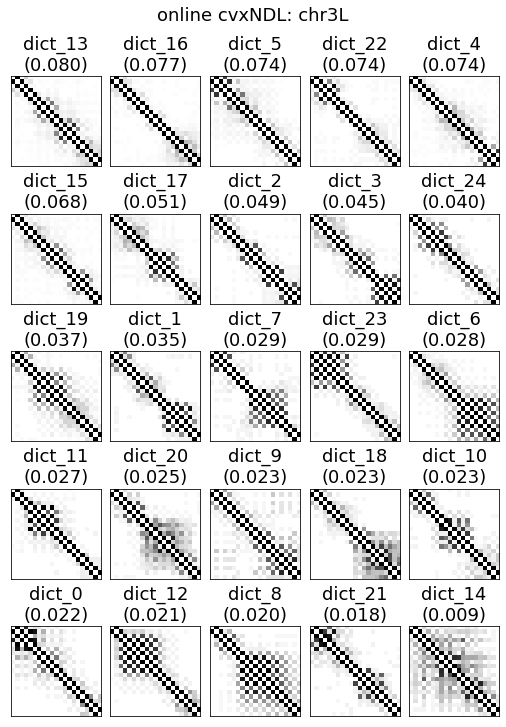

In [38]:
p2no_color_dicts = f'/data/shared/jianhao/online_cvxNDL_results/figures/{chromo}_fontsize18/{chromo}_dictionary_all_grey'
plot_df_in_grid(sorted_ocmf_dict_val_df_by_At, threshold = None, 
                grid_size = (5, 5), figsize = (7, 10),
                sub_titles= sorted_subtitles_by_At,
                title = f'online cvxNDL: {chromo}', 
               p2savefig = p2no_color_dicts)

## Dictionary density + importance score

In [50]:
sorted_ocmf_dict_val_df_by_At

,Principle component 0,Principle component 1,Principle component 2,Principle component 3,Principle component 4,Principle component 5,Principle component 6,Principle component 7,Principle component 8,Principle component 9,...,Principle component 431,Principle component 432,Principle component 433,Principle component 434,Principle component 435,Principle component 436,Principle component 437,Principle component 438,Principle component 439,Principle component 440
13,0.0,1.0,0.036181,0.298263,0.036181,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.041567,0.026003,0.080139,0.120992,0.193830,0.273357,0.224640,1.0,0.0
16,0.0,1.0,0.059408,0.221027,0.026134,0.000000,0.000000,0.029609,0.000000,0.000000,...,0.015049,0.000000,0.093656,0.083898,0.072888,0.163598,0.047286,0.210835,1.0,0.0
5,0.0,1.0,0.035180,0.794944,0.035180,0.096876,0.035180,0.000000,0.035180,0.000000,...,0.000000,0.082885,0.000000,0.000000,0.108401,0.000000,0.317695,0.029948,1.0,0.0
22,0.0,1.0,0.048125,0.139248,0.048125,0.139248,0.060604,0.000000,0.000000,0.000000,...,0.051822,0.000000,0.000000,0.000000,0.047976,0.000000,0.210396,0.099929,1.0,0.0
4,0.0,1.0,0.089404,0.148650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.046431,0.046431,0.118823,0.036091,0.822215,0.023365,1.0,0.0
15,0.0,1.0,0.073544,0.185729,0.000000,0.056949,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.067656,0.021163,0.035605,0.049381,0.117815,1.0,0.0
17,0.0,1.0,0.119067,0.119526,0.091621,0.056623,0.084137,0.063102,0.055618,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.055965,0.039752,0.207836,0.096375,1.0,0.0
2,0.0,1.0,0.082204,0.325982,0.000000,0.158619,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.086545,0.074127,0.086545,0.154305,0.161203,0.869331,0.000000,1.0,0.0
3,0.0,1.0,0.047777,0.309965,0.067782,0.053893,0.067782,0.000000,0.000000,0.000000,...,0.067782,0.000000,0.067782,0.000000,0.802847,0.000000,0.926523,0.000000,1.0,0.0
24,0.0,1.0,0.000000,0.126788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.188618,0.000000,0.188618,0.184364,1.0,0.0


In [51]:
sorted_importance_score = importance_score[descending_order_of_At]

In [52]:
sorted_importance_score

array([0.08047598, 0.07658698, 0.07405919, 0.07394807, 0.07365739,
       0.06762956, 0.05134418, 0.04860674, 0.04545787, 0.03997707,
       0.03682665, 0.03503473, 0.02932818, 0.02851004, 0.0277298 ,
       0.02651209, 0.02466605, 0.02332942, 0.02323378, 0.02313454,
       0.02228146, 0.02062968, 0.0195335 , 0.01803657, 0.00947048])

## plot convex hull of representative regions

In [39]:
def plot_cvx_hull(ax, df_in, weight = None, k = 21, title = ''):
#     fig = plt.figure()
#     ax = fig.subplots()
    
    if weight is None:
        average_row = df_in.mean(axis = 0).values
    else:
        average_row = (df_in * weight.reshape(-1, 1)).sum(axis = 0).values
    bin_row_mat = average_row.reshape(k, k)

    ax.imshow(bin_row_mat, cmap = 'Greys')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

#     plt.show()
#     plt.close()
    return ax

In [40]:
df_W_hat = pd.DataFrame(data = W_hat, columns = [f'w_cluster_{x}' for x in range(W_hat.shape[1])])

In [41]:
df_W_hat

,w_cluster_0,w_cluster_1,w_cluster_2,w_cluster_3,w_cluster_4,w_cluster_5,w_cluster_6,w_cluster_7,w_cluster_8,w_cluster_9,...,w_cluster_15,w_cluster_16,w_cluster_17,w_cluster_18,w_cluster_19,w_cluster_20,w_cluster_21,w_cluster_22,w_cluster_23,w_cluster_24
0,0.098575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.122000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.107448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.082535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.115402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108962
371,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128432
372,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076669
373,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079740


In [42]:
for x in importance_score:
    print(x)

0.02228145622876539
0.035034732660005195
0.048606743340885175
0.04545786530539931
0.0736573941905869
0.07405919026520681
0.027729804670674322
0.029328177972455374
0.01953350468624041
0.023329419748772978
0.023134536221317167
0.02651209157338719
0.020629677179272148
0.080475977006757
0.009470482434585991
0.06762955675485861
0.07658698332135336
0.05134417604667594
0.02323377519459143
0.03682665445464889
0.02466604622664672
0.018036571091162842
0.07394806847120293
0.02851004234145102
0.039977072613097034


In [43]:
descending_order_of_At[:5]

array([13, 16,  5, 22,  4])

In [44]:
# descending_order_of_At = np.arange(len(descending_order_of_At))

# Plot Dictionaries together with colored 

## No colorbar

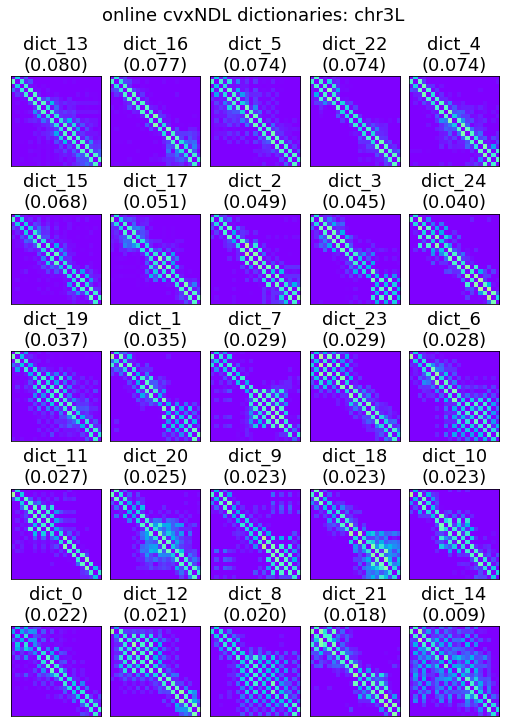

In [45]:
fig = plt.figure(figsize = (7, 10))
axes = fig.subplots(5, 5)

for ax_idx, cluster in enumerate(descending_order_of_At):
    cur_importance_score = importance_score[cluster]
    # get current dictionary row from for the current cluster with descending importance score.
    dict_row = ocmf_dict[ocmf_dict.label == f'ocmf: type {cluster + 1}']
    dict_row = dict_row[feature]
    
    # get representative regions for the current cluster.
    cur_label = f'group {cluster}'
    df_rep_val_df = rep_region[rep_region.label == cur_label].drop(columns = ['label'])
    
    # Find convex weight for each rep. in the corresponding column of cvx_weight, and the selected 
    # representative rows. 
    # df_W_hat is a column vector matrix. Each column is the weight for a cluster.
    cvx_weight = df_W_hat[rep_region.label == cur_label].values[:, cluster]
    descending_order_cvx_weight = cvx_weight.argsort()[::-1]
    
    # sort representative by their cvx weights. 
    sorted_df_rep_val_df_by_cvx_weight = df_rep_val_df.iloc[descending_order_cvx_weight]
#     print('cluster :', cluster)
    
    recon_dict_row = np.zeros_like(dict_row.values)
    colormapped_dict_row = np.zeros_like(recon_dict_row)
    
    for idx, (_, row) in enumerate(sorted_df_rep_val_df_by_cvx_weight.iterrows()):

        row_in = row.values
        cur_rep_idx = descending_order_cvx_weight[idx]
        cur_weight = cvx_weight[cur_rep_idx]
        
#         print('-' * 7, f'cluster {cluster}, rep {cur_rep_idx}, pos in {idx}', '-' * 7)
        
        if warning_flag:
            # even though used old dataset, try to find if matching in new dataset exists.
            # always true: df_raw_data == X_df != df_raw_data_matched_emb
            sample_idx_in_subgraphs = (df_raw_data_matched_emb == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data_matched_emb.loc[sample_idx_in_subgraphs]
            
            if len(samples_from_df_raw_data) == 0:
#                 print('no match of row adj in new dataset with embedding. Use OLD dataset')
                sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
                samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
                
            
        else:
            # no warning sign. we are using new dataset so there is no error.
            # df_raw_data == X_df == df_raw_data_matched_emb.
            sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
        
        # In case there are multiple samples with same weight matrices, select the first one.
        samples_from_df_raw_data = samples_from_df_raw_data.iloc[0]
        
        
        # Get node embeddings. 
        node_embedding_of_samples = df_node_all.loc[sample_idx_in_subgraphs].iloc[0].values
        
    
        # map current rep adjacency to genome id. 
        VID_of_samples = [int(x.strip('V')) for x in node_embedding_of_samples]
        genome_id_mapped_rep_row = convert_row_in_adj_to_vid(row_in, VID_of_samples)
        
        # recompute the cvx combination of rep and its color-coded vid. 
        cur_cvx_weight = cvx_weight[descending_order_cvx_weight][idx]
        recon_dict_row += cur_cvx_weight * row_in 
        colormapped_dict_row += cur_cvx_weight * genome_id_mapped_rep_row
        
    if not np.isclose(recon_dict_row, dict_row.values).all():
        break
    else:
        ax_row, ax_col = ax_idx // 5, ax_idx % 5
        cur_ax = axes[ax_row, ax_col]

        
        _, _, im = plot_one_color_row(cur_ax, colormapped_dict_row, 
                           title = f'dict_{cluster}\n({cur_importance_score:.3f})',
                            vmin = vid_lower_bound, vmax = vid_upper_bound)

        
plt.suptitle(f'online cvxNDL dictionaries: {chromo}', fontsize = 18, y = 1.01)
plt.tight_layout(pad = 0.6, rect = [0, 0, 1, 1.01])

# fig.subplots_adjust(right = 0.9)
# cbar_ax = fig.add_axes([0.9, 0.1, 0.03, 0.75])
# plt.colorbar(im, cax = cbar_ax)
# cbar_ax.tick_params(labelsize = 14, rotation = 90)


# p2fig_folder = f'/data/shared/jianhao/online_cvxNDL_results/figures/{chromo}_fontsize18'

p2fig_folder = f'/data/shared/jianhao/online_cvxNDL_results/figures/{chromo}_nocbar'
if not osp.isdir(p2fig_folder):
    os.makedirs(p2fig_folder)
p2savefig = osp.join(p2fig_folder, f'{chromo}_dictionary_all')


plt.savefig(p2savefig, bbox_inches = 'tight')
plt.show()
plt.close()
        
        
#         break
#     break
    
    

## With colorbar

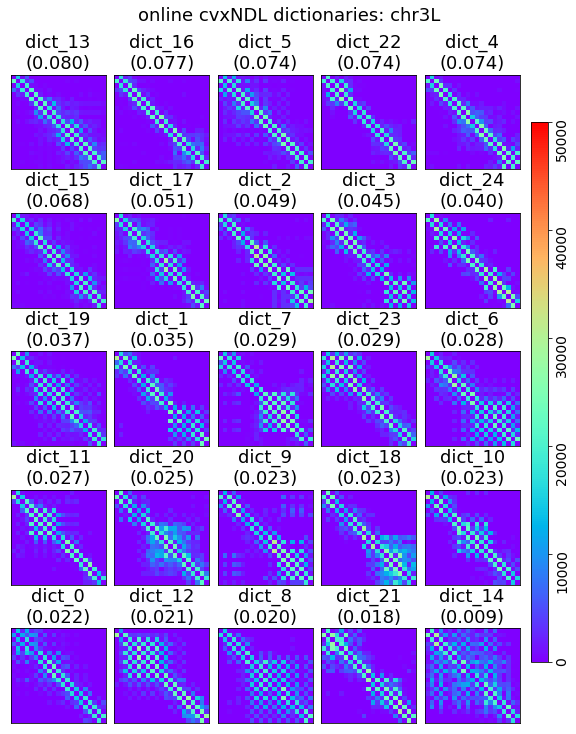

In [46]:
fig = plt.figure(figsize = (8, 10))
axes = fig.subplots(5, 5)

for ax_idx, cluster in enumerate(descending_order_of_At):
    cur_importance_score = importance_score[cluster]
    # get current dictionary row from for the current cluster with descending importance score.
    dict_row = ocmf_dict[ocmf_dict.label == f'ocmf: type {cluster + 1}']
    dict_row = dict_row[feature]
    
    # get representative regions for the current cluster.
    cur_label = f'group {cluster}'
    df_rep_val_df = rep_region[rep_region.label == cur_label].drop(columns = ['label'])
    
    # Find convex weight for each rep. in the corresponding column of cvx_weight, and the selected 
    # representative rows. 
    # df_W_hat is a column vector matrix. Each column is the weight for a cluster.
    cvx_weight = df_W_hat[rep_region.label == cur_label].values[:, cluster]
    descending_order_cvx_weight = cvx_weight.argsort()[::-1]
    
    # sort representative by their cvx weights. 
    sorted_df_rep_val_df_by_cvx_weight = df_rep_val_df.iloc[descending_order_cvx_weight]
#     print('cluster :', cluster)
    
    recon_dict_row = np.zeros_like(dict_row.values)
    colormapped_dict_row = np.zeros_like(recon_dict_row)
    
    for idx, (_, row) in enumerate(sorted_df_rep_val_df_by_cvx_weight.iterrows()):

        row_in = row.values
        cur_rep_idx = descending_order_cvx_weight[idx]
        cur_weight = cvx_weight[cur_rep_idx]
        
#         print('-' * 7, f'cluster {cluster}, rep {cur_rep_idx}, pos in {idx}', '-' * 7)
        
        if warning_flag:
            # even though used old dataset, try to find if matching in new dataset exists.
            # always true: df_raw_data == X_df != df_raw_data_matched_emb
            sample_idx_in_subgraphs = (df_raw_data_matched_emb == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data_matched_emb.loc[sample_idx_in_subgraphs]
            
            if len(samples_from_df_raw_data) == 0:
#                 print('no match of row adj in new dataset with embedding. Use OLD dataset')
                sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
                samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
                
            
        else:
            # no warning sign. we are using new dataset so there is no error.
            # df_raw_data == X_df == df_raw_data_matched_emb.
            sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
        
        # In case there are multiple samples with same weight matrices, select the first one.
        samples_from_df_raw_data = samples_from_df_raw_data.iloc[0]
        
        
        # Get node embeddings. 
        node_embedding_of_samples = df_node_all.loc[sample_idx_in_subgraphs].iloc[0].values
        
    
        # map current rep adjacency to genome id. 
        VID_of_samples = [int(x.strip('V')) for x in node_embedding_of_samples]
        genome_id_mapped_rep_row = convert_row_in_adj_to_vid(row_in, VID_of_samples)
        
        # recompute the cvx combination of rep and its color-coded vid. 
        cur_cvx_weight = cvx_weight[descending_order_cvx_weight][idx]
        recon_dict_row += cur_cvx_weight * row_in 
        colormapped_dict_row += cur_cvx_weight * genome_id_mapped_rep_row
        
    if not np.isclose(recon_dict_row, dict_row.values).all():
        break
    else:
        ax_row, ax_col = ax_idx // 5, ax_idx % 5
        cur_ax = axes[ax_row, ax_col]

        
        _, _, im = plot_one_color_row(cur_ax, colormapped_dict_row, 
                           title = f'dict_{cluster}\n({cur_importance_score:.3f})',
                            vmin = vid_lower_bound, vmax = vid_upper_bound)

        
plt.suptitle(f'online cvxNDL dictionaries: {chromo}', fontsize = 18, y = 1.01)
plt.tight_layout(pad = 0.6, rect = [0, 0, 1, 1.01])

fig.subplots_adjust(right = 0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.03, 0.75])
plt.colorbar(im, cax = cbar_ax)
cbar_ax.tick_params(labelsize = 14, rotation = 90)


p2fig_folder = f'/data/shared/jianhao/online_cvxNDL_results/figures/{chromo}_fontsize18'

# p2fig_folder = f'/data/shared/jianhao/online_cvxNDL_results/figures/{chromo}_nocbar'
if not osp.isdir(p2fig_folder):
    os.makedirs(p2fig_folder)
p2savefig = osp.join(p2fig_folder, f'{chromo}_dictionary_all')


plt.savefig(p2savefig, bbox_inches = 'tight')
plt.show()
plt.close()
        
        
#         break
#     break
    
    

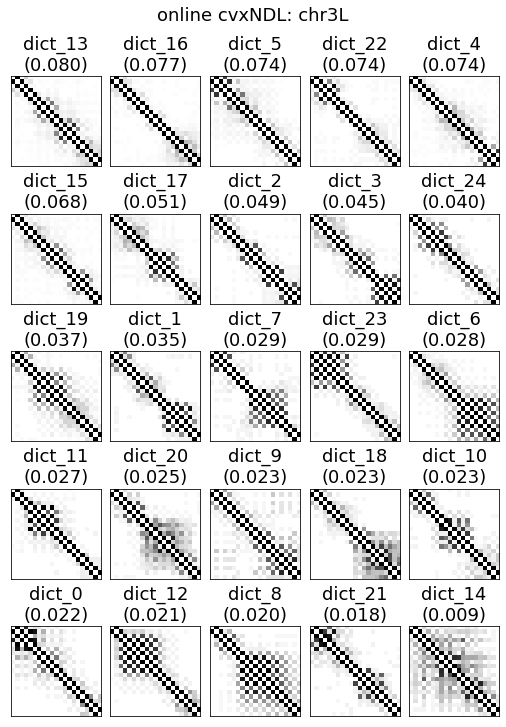

In [47]:
plot_df_in_grid(sorted_ocmf_dict_val_df_by_At, threshold = None, 
                grid_size = (5, 5), figsize = (7, 10),
                sub_titles= sorted_subtitles_by_At,
                title = f'online cvxNDL: {chromo}')

# plot indiviual dictionay. 

cluster : 13 
Num rep: 32
---


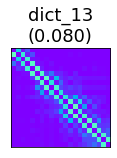

cluster : 16 
Num rep: 30
---


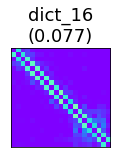

cluster : 5 
Num rep: 22
---


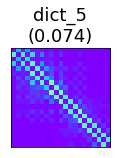

cluster : 22 
Num rep: 19
---


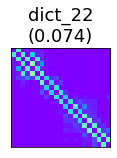

cluster : 4 
Num rep: 25
---


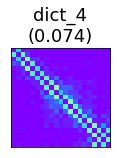

cluster : 15 
Num rep: 28
---


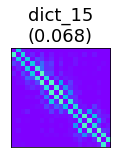

cluster : 17 
Num rep: 19
---


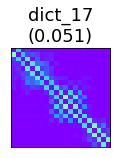

cluster : 2 
Num rep: 14
---


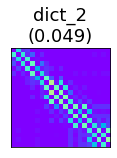

cluster : 3 
Num rep: 14
---


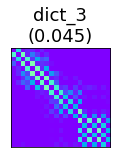

cluster : 24 
Num rep: 10
---


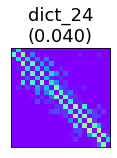

cluster : 19 
Num rep: 14
---


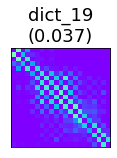

cluster : 1 
Num rep: 11
---


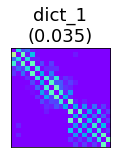

cluster : 7 
Num rep: 11
---


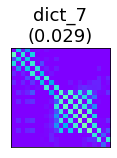

cluster : 23 
Num rep: 13
---


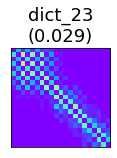

cluster : 6 
Num rep: 13
---


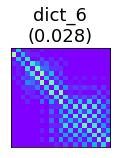

cluster : 11 
Num rep: 10
---


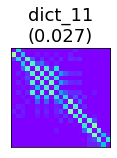

cluster : 20 
Num rep: 10
---


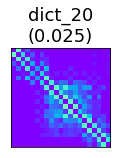

cluster : 9 
Num rep: 10
---


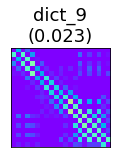

cluster : 18 
Num rep: 10
---


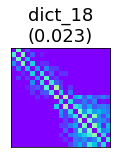

cluster : 10 
Num rep: 10
---


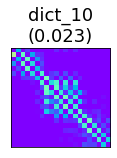

cluster : 0 
Num rep: 10
---


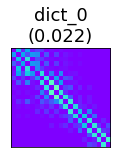

cluster : 12 
Num rep: 10
---


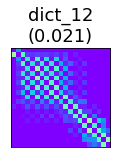

cluster : 8 
Num rep: 10
---


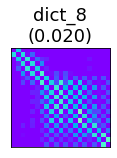

cluster : 21 
Num rep: 10
---


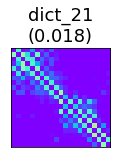

cluster : 14 
Num rep: 10
---


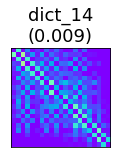

In [48]:
# fig = plt.figure(figsize = (20, 16))
# axes = fig.subplots(5, 5)

for ax_idx, cluster in enumerate(descending_order_of_At):
    cur_importance_score = importance_score[cluster]
    # get current dictionary row from for the current cluster with descending importance score.
    dict_row = ocmf_dict[ocmf_dict.label == f'ocmf: type {cluster + 1}']
    dict_row = dict_row[feature]
    
    # get representative regions for the current cluster.
    cur_label = f'group {cluster}'
    df_rep_val_df = rep_region[rep_region.label == cur_label].drop(columns = ['label'])
    
    # Find convex weight for each rep. in the corresponding column of cvx_weight, and the selected 
    # representative rows. 
    # df_W_hat is a column vector matrix. Each column is the weight for a cluster.
    cvx_weight = df_W_hat[rep_region.label == cur_label].values[:, cluster]
    descending_order_cvx_weight = cvx_weight.argsort()[::-1]
    
    # sort representative by their cvx weights. 
    sorted_df_rep_val_df_by_cvx_weight = df_rep_val_df.iloc[descending_order_cvx_weight]
    print('cluster :', cluster,'\nNum rep:', len(sorted_df_rep_val_df_by_cvx_weight))
    print('-' * 3)
    
    recon_dict_row = np.zeros_like(dict_row.values)
    colormapped_dict_row = np.zeros_like(recon_dict_row)
    
    for idx, (_, row) in enumerate(sorted_df_rep_val_df_by_cvx_weight.iterrows()):

        row_in = row.values
        cur_rep_idx = descending_order_cvx_weight[idx]
        cur_weight = cvx_weight[cur_rep_idx]
        
#         print('-' * 7, f'cluster {cluster}, rep {cur_rep_idx}, pos in {idx}', '-' * 7)
        
        if warning_flag:
            # even though used old dataset, try to find if matching in new dataset exists.
            # always true: df_raw_data == X_df != df_raw_data_matched_emb
            sample_idx_in_subgraphs = (df_raw_data_matched_emb == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data_matched_emb.loc[sample_idx_in_subgraphs]
            
            if len(samples_from_df_raw_data) == 0:
#                 print('no match of row adj in new dataset with embedding. Use OLD dataset')
                sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
                samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
                
            
        else:
            # no warning sign. we are using new dataset so there is no error.
            # df_raw_data == X_df == df_raw_data_matched_emb.
            sample_idx_in_subgraphs = (df_raw_data == row_in).all(axis = 1)
            samples_from_df_raw_data = df_raw_data.loc[sample_idx_in_subgraphs]
        
        # In case there are multiple samples with same weight matrices, select the first one.
        samples_from_df_raw_data = samples_from_df_raw_data.iloc[0]
        
        
        # Get node embeddings. 
        node_embedding_of_samples = df_node_all.loc[sample_idx_in_subgraphs].iloc[0].values
        
    
        # map current rep adjacency to genome id. 
        VID_of_samples = [int(x.strip('V')) for x in node_embedding_of_samples]
        genome_id_mapped_rep_row = convert_row_in_adj_to_vid(row_in, VID_of_samples)
        
        # recompute the cvx combination of rep and its color-coded vid. 
        cur_cvx_weight = cvx_weight[descending_order_cvx_weight][idx]
        recon_dict_row += cur_cvx_weight * row_in 
        colormapped_dict_row += cur_cvx_weight * genome_id_mapped_rep_row
        
    if not np.isclose(recon_dict_row, dict_row.values).all():
        break
    else:

        fig = plt.figure(figsize = (2.3, 2.3))
        cur_ax = fig.add_subplot(111)
#         p2fig_folder = f'/data/shared/jianhao/online_cvxNDL_results/figures/{chromo}'
        p2fig_folder = f'/data/shared/jianhao/online_cvxNDL_results/figures/{chromo}_fontsize18'
        if not osp.isdir(p2fig_folder):
            os.makedirs(p2fig_folder)
        p2savefig = osp.join(p2fig_folder, f'{chromo}_dictionary_{cluster}')
        
        _, _, im = plot_one_color_row(cur_ax, colormapped_dict_row, 
                           title = f'dict_{cluster}\n({cur_importance_score:.3f})',
                            vmin = vid_lower_bound, vmax = vid_upper_bound)



        plt.tight_layout()
        plt.savefig(p2savefig)
        plt.show()
        plt.close()
        
        
#         break
#     break
    
    

In [49]:
# dummy_colorbar = np.array([vid_lower_bound, vid_upper_bound] * 2).reshape((2, 2))
# plt.imshow(dummy_colorbar)

# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(cax=cax)
# plt.show()